# Keras - LSTM

bla

#### Importere biblioteker

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Making plots look better (Jupyter Notebook spesific)
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True

# Built in jupyter notebook commands
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### Importere datasett

In [2]:
data_raw = pd.read_csv('data_ytrevikna_advanced.csv',sep =';', low_memory = False)

data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237 entries, 0 to 5236
Data columns (total 66 columns):
YVIK-YtreVikna1.-G1-T4015A3 -0104    4954 non-null float64
RRS.S2502.Gunit.M1 G1.AVL            5237 non-null int64
YVIK-YtreVikna1.-G2-T4015A3 -0104    5222 non-null float64
RRS.S2502.Gunit.M2 G1.AVL            5237 non-null int64
YVIK-YtreVikna1.-G3-T4015A3 -0104    5222 non-null float64
RRS.S2502.Gunit.M3 G1.AVL            5237 non-null int64
YVIK-YtreVikna1.-G4-T4015A3 -0104    5222 non-null float64
RRS.S2502.Gunit.M4 G1.AVL            5237 non-null int64
YVIK-YtreVikna1.-G5-T4015A3 -0104    5222 non-null float64
RRS.S2502.Gunit.M5 G1.AVL            5237 non-null int64
YVIK-YtreVikna1.-G6-T4015A3 -0104    5222 non-null float64
RRS.S2502.Gunit.M6 G1.AVL            5237 non-null int64
YVIK-YtreVikna1.-G7-T4015A3 -0104    5222 non-null float64
RRS.S2502.Gunit.M7 G1.AVL            5237 non-null int64
YVIK-YtreVikna1.-G8-T4015A3 -0104    5222 non-null float64
RRS.S2502.Gunit.M8 G1.

In [3]:
data = data_raw.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4895 entries, 5 to 5236
Data columns (total 66 columns):
YVIK-YtreVikna1.-G1-T4015A3 -0104    4895 non-null float64
RRS.S2502.Gunit.M1 G1.AVL            4895 non-null int64
YVIK-YtreVikna1.-G2-T4015A3 -0104    4895 non-null float64
RRS.S2502.Gunit.M2 G1.AVL            4895 non-null int64
YVIK-YtreVikna1.-G3-T4015A3 -0104    4895 non-null float64
RRS.S2502.Gunit.M3 G1.AVL            4895 non-null int64
YVIK-YtreVikna1.-G4-T4015A3 -0104    4895 non-null float64
RRS.S2502.Gunit.M4 G1.AVL            4895 non-null int64
YVIK-YtreVikna1.-G5-T4015A3 -0104    4895 non-null float64
RRS.S2502.Gunit.M5 G1.AVL            4895 non-null int64
YVIK-YtreVikna1.-G6-T4015A3 -0104    4895 non-null float64
RRS.S2502.Gunit.M6 G1.AVL            4895 non-null int64
YVIK-YtreVikna1.-G7-T4015A3 -0104    4895 non-null float64
RRS.S2502.Gunit.M7 G1.AVL            4895 non-null int64
YVIK-YtreVikna1.-G8-T4015A3 -0104    4895 non-null float64
RRS.S2502.Gunit.M8 G1.

In [4]:
num_features = len(data.columns) -1
print(num_features)

65


#### Konvertere til numpy-arrays

In [5]:
# Konverterer pandas.DataFrame til en numpy array
all_features_and_target_value = data.values.astype("float32")

# Trekker ut alle features (5 aromepunkter med 4 features + delayed = 21 features)
x = all_features_and_target_value[:,0:num_features]

# Trekker ut produksjonen som y-verdi
y = all_features_and_target_value[:,num_features]

#### Train/test Split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 67, shuffle=False)

#### Skalere data

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Lage en scaler
scaler = MinMaxScaler()

# Anvende på features, her lagret i variablen x.
scaled_x_train = scaler.fit_transform(X_train)
scaled_x_test = scaler.transform(X_test)

### Konvertere til tidserie matrise

In [8]:
# Definere variabler:
n_backward = 4

In [9]:
# Function for making time series
def make_time_series(row_features, look_back_num):
    list_of_matrices = []
    
    num_time_steps = look_back_num + 1
    
    i = num_time_steps
    
    while i < len(row_features):
        list_of_matrices.append(row_features[(i-num_time_steps):i,:])
        
        i = i + 1
    
    return list_of_matrices

In [10]:
x_train_matrix = np.asarray(make_time_series(X_train, n_backward))
x_test_matrix = np.asarray(make_time_series(X_test, n_backward))

In [11]:
x_train_matrix.shape

(3421, 5, 65)

In [12]:
x_train_matrix[0].shape

(5, 65)

#### Fjerne 'n_backward' antall rader, for å få like store sett

In [13]:
y_train_matrix = np.delete(y_train, [x for x in range(n_backward+1)], 0)
y_test_matrix = np.delete(y_test, [x for x in range(n_backward+1)], 0)

In [14]:
y_train_matrix.shape

(3421,)

# Keras

In [15]:
import tensorflow as tf

#### Importere modellen

In [16]:
from tensorflow.contrib.keras import models

In [17]:
dnn_keras_model = models.Sequential()

#### Sette opp layers

In [18]:
from tensorflow.contrib.keras import layers

In [19]:
# Input layer
dnn_keras_model.add(layers.LSTM(units=32, return_sequences = True, input_shape=(x_train_matrix.shape[1],x_train_matrix.shape[2]) ))

In [20]:
'''Hidden Layers'''

dnn_keras_model.add(layers.LSTM(units=16))

In [21]:
# Output Layer
dnn_keras_model.add(layers.Dense(1))

#### Kompilere modellen

In [22]:
from tensorflow.contrib.keras import losses,optimizers,metrics,activations

In [23]:
#Kompilere - Alternative lossfunctions: mean_squared_error
dnn_keras_model.compile(optimizer='adam', loss = 'mean_absolute_error')

#### Trene modellen

In [24]:
from tensorflow.contrib.keras import losses,optimizers,metrics,activations

#### Callbacks og checkpoints

In [25]:
from tensorflow.contrib.keras import callbacks

In [26]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=500)

checkpoint = callbacks.ModelCheckpoint('checkpoint_model_LSTM_advanced.h5', monitor = 'val_loss', 
                                       verbose = 1, save_best_only= True, mode= 'min')

In [27]:
# Trene modellen
np.random.seed(7)
dnn_keras_model.fit(x_train_matrix,y_train_matrix, epochs = 1000, batch_size=32, verbose=2, 
                       validation_split=0.2,
                       callbacks=[checkpoint,early_stopping])


# validation_split=0.20
#validation_data=(X_test, y_test)

Train on 2736 samples, validate on 685 samples
Epoch 1/1000
Epoch 00000: val_loss improved from inf to 11.21393, saving model to checkpoint_model_LSTM_advanced.h5
3s - loss: 12.2046 - val_loss: 11.2139
Epoch 2/1000
Epoch 00001: val_loss improved from 11.21393 to 10.59710, saving model to checkpoint_model_LSTM_advanced.h5
0s - loss: 10.4013 - val_loss: 10.5971
Epoch 3/1000
Epoch 00002: val_loss improved from 10.59710 to 10.40242, saving model to checkpoint_model_LSTM_advanced.h5
0s - loss: 10.2279 - val_loss: 10.4024
Epoch 4/1000
Epoch 00003: val_loss improved from 10.40242 to 10.28196, saving model to checkpoint_model_LSTM_advanced.h5
0s - loss: 10.1618 - val_loss: 10.2820
Epoch 5/1000
Epoch 00004: val_loss improved from 10.28196 to 10.20929, saving model to checkpoint_model_LSTM_advanced.h5
0s - loss: 10.1300 - val_loss: 10.2093
Epoch 6/1000
Epoch 00005: val_loss improved from 10.20929 to 10.14831, saving model to checkpoint_model_LSTM_advanced.h5
0s - loss: 10.1123 - val_loss: 10.148

Epoch 00076: val_loss did not improve
0s - loss: 10.0699 - val_loss: 10.0257
Epoch 78/1000
Epoch 00077: val_loss did not improve
0s - loss: 10.0708 - val_loss: 10.0143
Epoch 79/1000
Epoch 00078: val_loss did not improve
0s - loss: 10.0748 - val_loss: 10.0315
Epoch 80/1000
Epoch 00079: val_loss did not improve
0s - loss: 10.0694 - val_loss: 9.9987
Epoch 81/1000
Epoch 00080: val_loss improved from 9.98450 to 9.97934, saving model to checkpoint_model_LSTM_advanced.h5
0s - loss: 10.0807 - val_loss: 9.9793
Epoch 82/1000
Epoch 00081: val_loss did not improve
0s - loss: 10.0752 - val_loss: 10.0207
Epoch 83/1000
Epoch 00082: val_loss did not improve
0s - loss: 10.0715 - val_loss: 10.0373
Epoch 84/1000
Epoch 00083: val_loss did not improve
0s - loss: 10.0708 - val_loss: 10.0447
Epoch 85/1000
Epoch 00084: val_loss did not improve
0s - loss: 10.0687 - val_loss: 9.9964
Epoch 86/1000
Epoch 00085: val_loss did not improve
0s - loss: 10.0698 - val_loss: 10.0018
Epoch 87/1000
Epoch 00086: val_loss did

Epoch 00162: val_loss improved from 9.95403 to 9.95073, saving model to checkpoint_model_LSTM_advanced.h5
0s - loss: 10.0655 - val_loss: 9.9507
Epoch 164/1000
Epoch 00163: val_loss did not improve
0s - loss: 10.0647 - val_loss: 9.9939
Epoch 165/1000
Epoch 00164: val_loss did not improve
0s - loss: 10.0611 - val_loss: 10.0059
Epoch 166/1000
Epoch 00165: val_loss did not improve
0s - loss: 10.0626 - val_loss: 10.0110
Epoch 167/1000
Epoch 00166: val_loss did not improve
0s - loss: 10.0637 - val_loss: 9.9922
Epoch 168/1000
Epoch 00167: val_loss did not improve
1s - loss: 10.0621 - val_loss: 9.9979
Epoch 169/1000
Epoch 00168: val_loss did not improve
0s - loss: 10.0611 - val_loss: 10.0114
Epoch 170/1000
Epoch 00169: val_loss did not improve
0s - loss: 10.0633 - val_loss: 9.9677
Epoch 171/1000
Epoch 00170: val_loss did not improve
0s - loss: 10.0641 - val_loss: 9.9989
Epoch 172/1000
Epoch 00171: val_loss did not improve
0s - loss: 10.0631 - val_loss: 9.9776
Epoch 173/1000
Epoch 00172: val_lo

Epoch 00251: val_loss did not improve
0s - loss: 10.0617 - val_loss: 10.0063
Epoch 253/1000
Epoch 00252: val_loss did not improve
0s - loss: 10.0588 - val_loss: 9.9843
Epoch 254/1000
Epoch 00253: val_loss did not improve
0s - loss: 10.0615 - val_loss: 9.9900
Epoch 255/1000
Epoch 00254: val_loss did not improve
0s - loss: 10.0624 - val_loss: 10.0332
Epoch 256/1000
Epoch 00255: val_loss did not improve
0s - loss: 10.0601 - val_loss: 10.0180
Epoch 257/1000
Epoch 00256: val_loss did not improve
0s - loss: 10.0603 - val_loss: 9.9806
Epoch 258/1000
Epoch 00257: val_loss did not improve
0s - loss: 10.0617 - val_loss: 9.9836
Epoch 259/1000
Epoch 00258: val_loss did not improve
1s - loss: 10.0600 - val_loss: 9.9901
Epoch 260/1000
Epoch 00259: val_loss did not improve
0s - loss: 10.0602 - val_loss: 10.0227
Epoch 261/1000
Epoch 00260: val_loss did not improve
0s - loss: 10.0643 - val_loss: 10.0086
Epoch 262/1000
Epoch 00261: val_loss did not improve
0s - loss: 10.0617 - val_loss: 10.0392
Epoch 26

Epoch 00341: val_loss did not improve
0s - loss: 10.0591 - val_loss: 10.0055
Epoch 343/1000
Epoch 00342: val_loss did not improve
0s - loss: 10.0613 - val_loss: 9.9990
Epoch 344/1000
Epoch 00343: val_loss did not improve
0s - loss: 10.0616 - val_loss: 10.0001
Epoch 345/1000
Epoch 00344: val_loss did not improve
0s - loss: 10.0585 - val_loss: 10.0063
Epoch 346/1000
Epoch 00345: val_loss did not improve
0s - loss: 10.0589 - val_loss: 9.9762
Epoch 347/1000
Epoch 00346: val_loss did not improve
0s - loss: 10.0606 - val_loss: 9.9974
Epoch 348/1000
Epoch 00347: val_loss did not improve
0s - loss: 10.0581 - val_loss: 9.9987
Epoch 349/1000
Epoch 00348: val_loss did not improve
0s - loss: 10.0589 - val_loss: 10.0071
Epoch 350/1000
Epoch 00349: val_loss did not improve
0s - loss: 10.0584 - val_loss: 10.0064
Epoch 351/1000
Epoch 00350: val_loss did not improve
0s - loss: 10.0593 - val_loss: 9.9625
Epoch 352/1000
Epoch 00351: val_loss did not improve
0s - loss: 10.0604 - val_loss: 10.0113
Epoch 35

Epoch 00431: val_loss did not improve
0s - loss: 10.0557 - val_loss: 9.9917
Epoch 433/1000
Epoch 00432: val_loss did not improve
0s - loss: 10.0547 - val_loss: 9.9890
Epoch 434/1000
Epoch 00433: val_loss did not improve
0s - loss: 10.0567 - val_loss: 10.0217
Epoch 435/1000
Epoch 00434: val_loss did not improve
0s - loss: 10.0545 - val_loss: 9.9955
Epoch 436/1000
Epoch 00435: val_loss did not improve
0s - loss: 10.0545 - val_loss: 9.9914
Epoch 437/1000
Epoch 00436: val_loss did not improve
0s - loss: 10.0551 - val_loss: 9.9888
Epoch 438/1000
Epoch 00437: val_loss did not improve
0s - loss: 10.0608 - val_loss: 9.9947
Epoch 439/1000
Epoch 00438: val_loss did not improve
0s - loss: 10.0575 - val_loss: 10.0049
Epoch 440/1000
Epoch 00439: val_loss did not improve
0s - loss: 10.0563 - val_loss: 10.0024
Epoch 441/1000
Epoch 00440: val_loss did not improve
0s - loss: 10.0556 - val_loss: 9.9813
Epoch 442/1000
Epoch 00441: val_loss did not improve
0s - loss: 10.0559 - val_loss: 10.0174
Epoch 443/

Epoch 00521: val_loss did not improve
0s - loss: 10.0561 - val_loss: 9.9805
Epoch 523/1000
Epoch 00522: val_loss did not improve
0s - loss: 10.0535 - val_loss: 9.9979
Epoch 524/1000
Epoch 00523: val_loss did not improve
0s - loss: 10.0578 - val_loss: 9.9891
Epoch 525/1000
Epoch 00524: val_loss did not improve
0s - loss: 10.0570 - val_loss: 9.9853
Epoch 526/1000
Epoch 00525: val_loss did not improve
0s - loss: 10.0541 - val_loss: 10.0084
Epoch 527/1000
Epoch 00526: val_loss did not improve
0s - loss: 10.0559 - val_loss: 9.9937
Epoch 528/1000
Epoch 00527: val_loss did not improve
0s - loss: 10.0530 - val_loss: 9.9882
Epoch 529/1000
Epoch 00528: val_loss did not improve
0s - loss: 10.0572 - val_loss: 10.0123
Epoch 530/1000
Epoch 00529: val_loss did not improve
0s - loss: 10.0572 - val_loss: 10.0368
Epoch 531/1000
Epoch 00530: val_loss did not improve
0s - loss: 10.0538 - val_loss: 10.0050
Epoch 532/1000
Epoch 00531: val_loss did not improve
0s - loss: 10.0563 - val_loss: 10.0301
Epoch 533

Epoch 00611: val_loss did not improve
0s - loss: 10.0546 - val_loss: 10.0198
Epoch 613/1000
Epoch 00612: val_loss did not improve
0s - loss: 10.0530 - val_loss: 10.0038
Epoch 614/1000
Epoch 00613: val_loss did not improve
0s - loss: 10.0541 - val_loss: 10.0107
Epoch 615/1000
Epoch 00614: val_loss did not improve
0s - loss: 10.0567 - val_loss: 9.9884
Epoch 616/1000
Epoch 00615: val_loss did not improve
0s - loss: 10.0558 - val_loss: 10.0007
Epoch 617/1000
Epoch 00616: val_loss did not improve
0s - loss: 10.0562 - val_loss: 9.9753
Epoch 618/1000
Epoch 00617: val_loss did not improve
0s - loss: 10.0542 - val_loss: 9.9997
Epoch 619/1000
Epoch 00618: val_loss did not improve
0s - loss: 10.0560 - val_loss: 10.0126
Epoch 620/1000
Epoch 00619: val_loss did not improve
0s - loss: 10.0546 - val_loss: 10.0109
Epoch 621/1000
Epoch 00620: val_loss did not improve
0s - loss: 10.0538 - val_loss: 10.0300
Epoch 622/1000
Epoch 00621: val_loss did not improve
0s - loss: 10.0548 - val_loss: 9.9780
Epoch 6

# Resultater

In [28]:
from sklearn import metrics

In [29]:
#finished_model = dnn_keras_model

finished_model = models.load_model('checkpoint_model_LSTM_advanced.h5')

#### Prediksjon på testsett

In [30]:
final_preds = finished_model.predict(x_test_matrix)

In [31]:
# 5000 epocs , b_size = 10, 24(24)[10](1)
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_test_matrix, final_preds))
print('Mean Squared Error: \t\t\t', metrics.mean_squared_error(y_test_matrix, final_preds))
print('Root Mean Squared Error: \t\t', np.sqrt(metrics.mean_squared_error(y_test_matrix, final_preds)))

Mean Absolute Error: 			 12.3592
Mean Squared Error: 			 230.741
Root Mean Squared Error: 		 15.1902


#### Prediksjon på treningdata

In [32]:
train_preds = finished_model.predict(x_train_matrix)

In [33]:
# 70% av data (benyttet til treningen)
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_train_matrix,train_preds))
print('Mean Squared Error: \t\t\t', metrics.mean_squared_error(y_train_matrix, train_preds))
print('Root Mean Squared Error: \t\t', np.sqrt(metrics.mean_squared_error(y_train_matrix, train_preds)))

Mean Absolute Error: 			 10.0439
Mean Squared Error: 			 161.323
Root Mean Squared Error: 		 12.7013


# Visualisere resultater

#### Lager oversikt over testdataen

In [34]:
predictions = list(final_preds)

predictions_list = []

for pred in predictions:
    predictions_list.append(pred[0])

In [35]:
Oversikt = pd.DataFrame(data = {'real': y_test_matrix, 'predicitions': predictions_list})

Oversikt['differanse'] = Oversikt['real'] - Oversikt['predicitions'] 

Oversikt['abs_diff'] = Oversikt['differanse'].apply(abs)

### Scatterplot med fargekodede prediskjoner

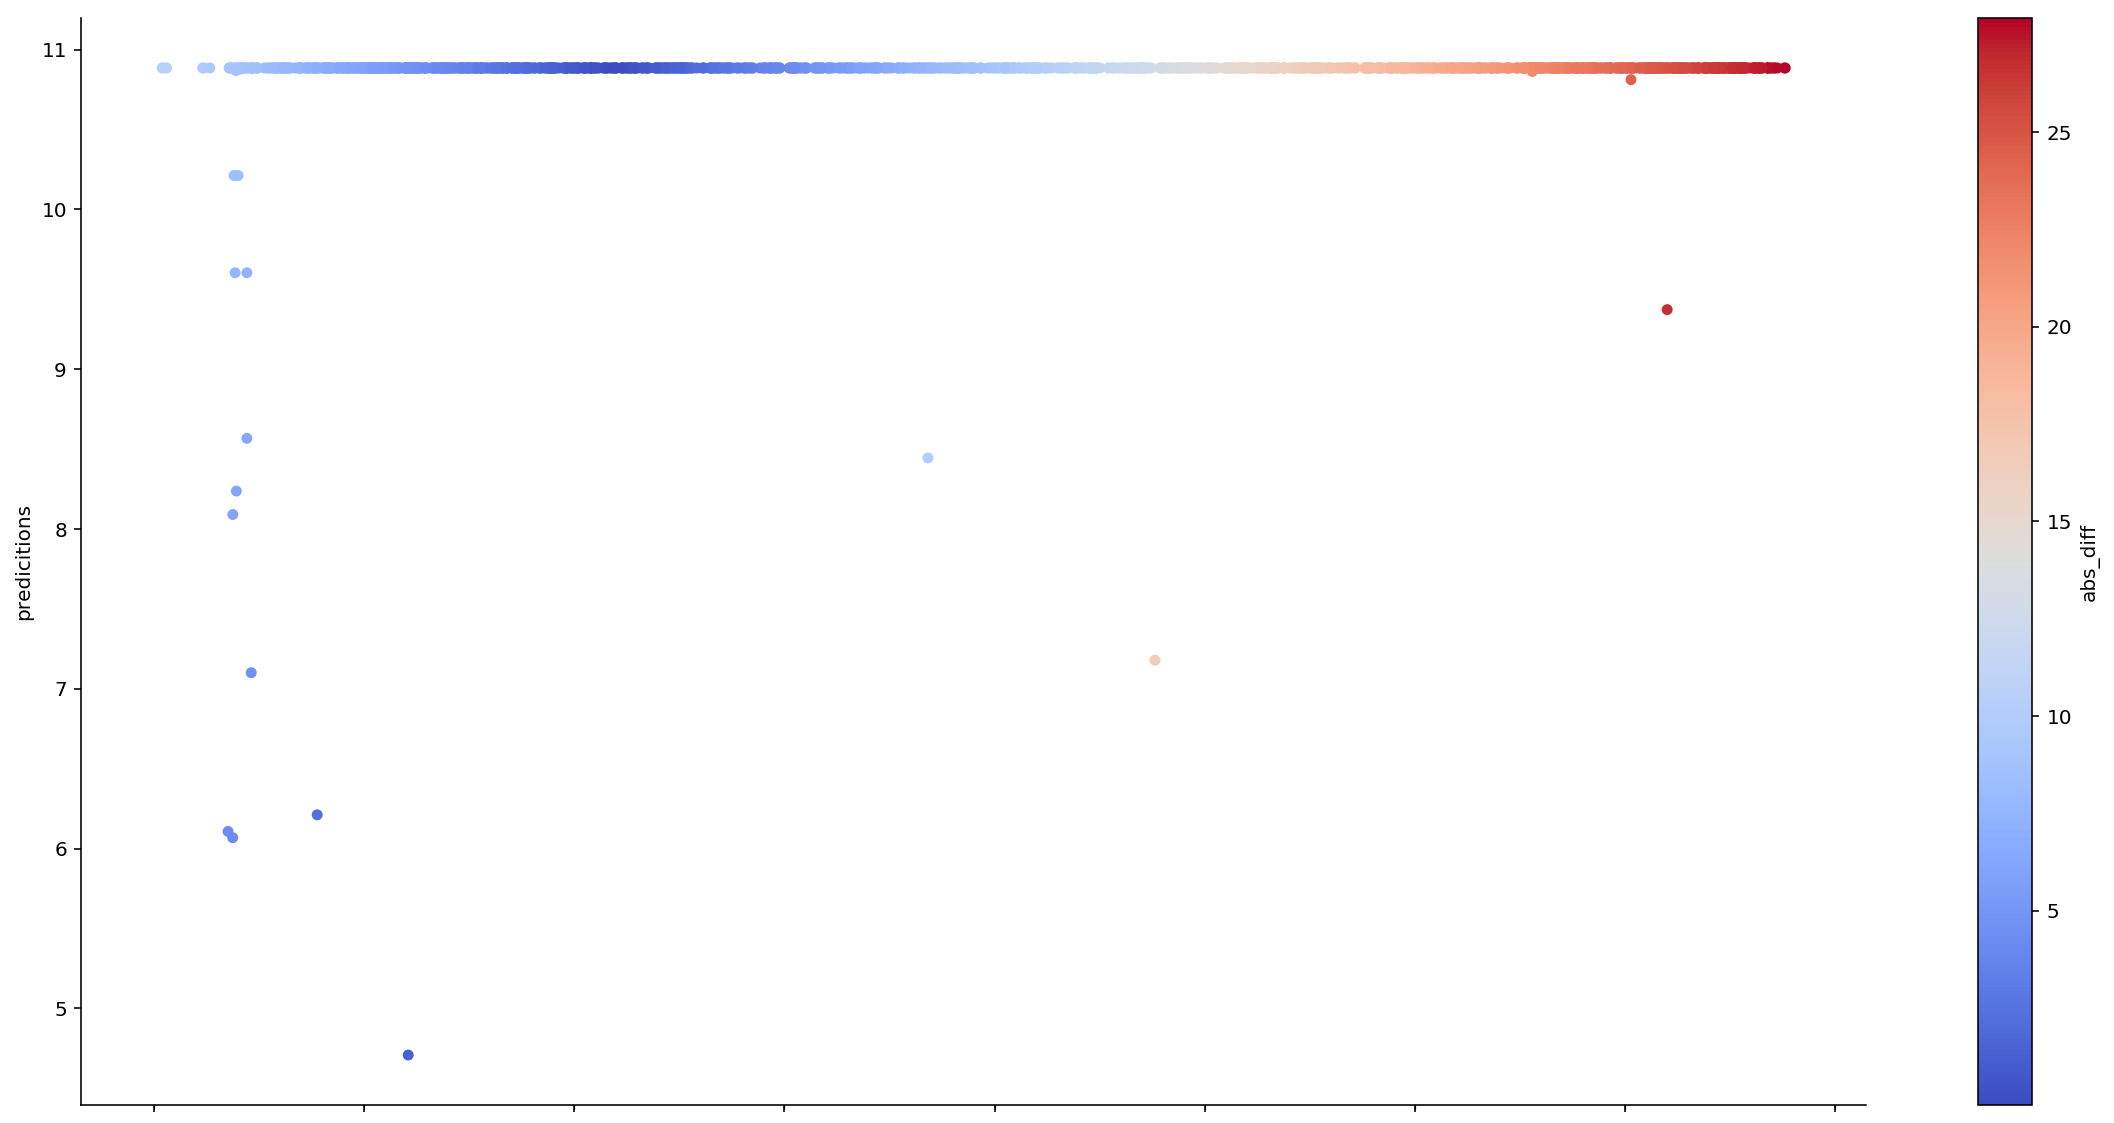

In [36]:
ax = Oversikt.plot.scatter(x='real',y='predicitions',
                   c='abs_diff',cmap='coolwarm', figsize = (20,10))

ax.set_xlabel("x label")

#remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig = ax.get_figure()
#fig.savefig('keras_model.png')

### Feilfordelingen av prediksjoner

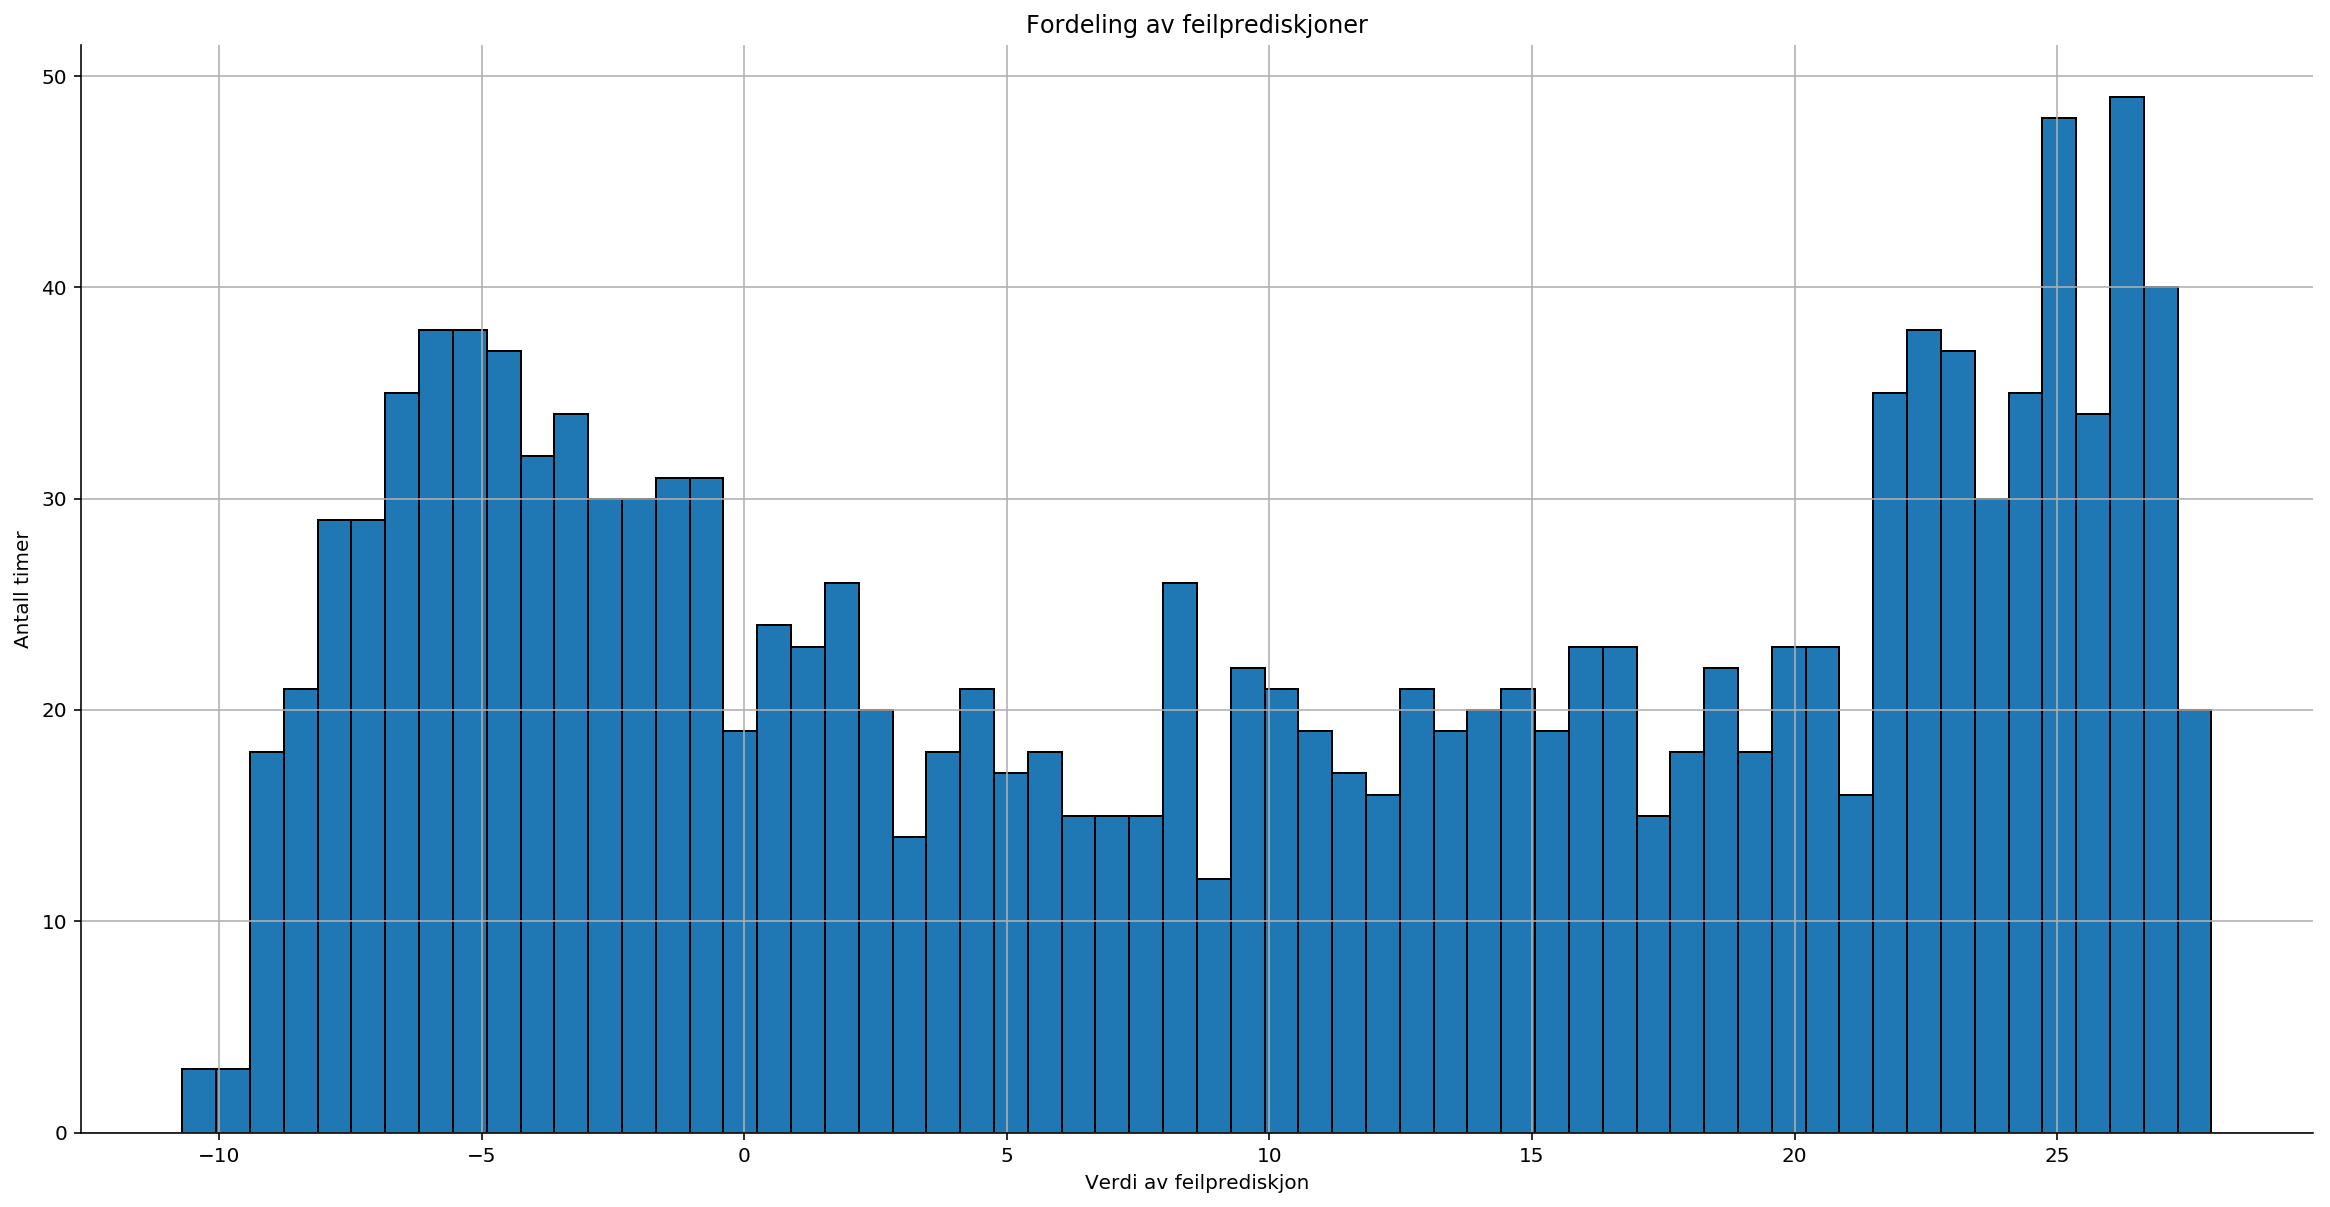

In [37]:
ax = Oversikt['differanse'].hist(bins=60,figsize = (20,10))

plt.xlabel('Verdi av feilprediskjon')
plt.ylabel('Antall timer')
plt.title('Fordeling av feilprediskjoner')

#remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig = ax.get_figure()
#fig.savefig('hist av abs.png')

# Ekte plott av prediksjonene

#### Forsøk på å hente ut et utdrag av dataen

In [38]:
all_predictions = finished_model.predict(x[:,:])

predictions_all = list(all_predictions)

predictions_all_list = []

for pred in predictions_all:
    predictions_all_list.append(pred[0])
    
timeline = pd.DataFrame(data = {'real': y[:], 'predicitions': predictions_all_list})

# Adjust in order to plot 'dagens modell'
data_raw.dropna(inplace=True)
data_raw.reset_index(inplace=True)

ValueError: Error when checking : expected lstm_1_input to have 3 dimensions, but got array with shape (4895, 65)

#### Tidsplot av data

In [ ]:
# Justere tidslinjen på plottet
start = 0
slutt = 20

ax = timeline.loc[start:slutt,'real'].plot(figsize=(20,8))
ax = timeline.loc[start:slutt,'predicitions'].plot(figsize=(20,8))
ax = data_raw.loc[start:slutt,'YVIK-YtreVikna1-Sum-produksjon'].plot(figsize=(20,8))

 
plt.xlabel('Tid (antall timer)')
plt.ylabel('Produksjon i Mega Watt (MW)')
plt.title('Utdrag fra tidsperioden')

plt.legend(loc='best')

#remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Saves figure
fig = ax.get_figure()
#fig.savefig('september10.png')